In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Select stocks
tickers = ['AAPL', 'MSFT', 'XOM', 'CVX', 'JPM', 'BAC', 'JNJ', 'PFE', 'WMT', 'AMZN']

# Full names
asset_names = [
    'Apple (Tech)',
    'Microsoft (Tech)',
    'ExxonMobil (Energy)',
    'Chevron (Energy)',
    'JPMorgan (Finance)',
    'Bank of America (Finance)',
    'Johnson & Johnson (Healthcare)',
    'Pfizer (Healthcare)',
    'Walmart (Retail)',
    'Amazon (E-commerce)'
]

# Time period
end_date = datetime.now()
start_date = end_date - timedelta(days=3*365)

print(f"\nTickers: {tickers}")
print(f"Time period: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
print(f"Number of stocks: {len(tickers)}")



Tickers: ['AAPL', 'MSFT', 'XOM', 'CVX', 'JPM', 'BAC', 'JNJ', 'PFE', 'WMT', 'AMZN']
Time period: 2022-10-27 to 2025-10-26
Number of stocks: 10


In [2]:
try:
    raw_data = yf.download(tickers, start=start_date, end=end_date, 
                           progress=False, auto_adjust=True)
    
    if isinstance(raw_data.columns, pd.MultiIndex):
        data = raw_data['Close']
    else:
        data = raw_data
    
    data = data[tickers]

    print(f"  - Date range: {data.index[0].strftime('%Y-%m-%d')} to {data.index[-1].strftime('%Y-%m-%d')}")
    print(f"  - Number of trading days: {len(data)}")
    print(f"  - Missing values: {data.isnull().sum().sum()}")
    
    if data.isnull().sum().sum() > 0:
        data = data.fillna(method='ffill').fillna(method='bfill')
    
except Exception as e:
    print(f"\n ERROR: {e}")
    exit(1)

daily_returns = data.pct_change().dropna()

expected_returns = daily_returns.mean() * 252 * 100
expected_returns = expected_returns.values

volatility = daily_returns.std() * np.sqrt(252) * 100
volatility = volatility.values

covariance_matrix = daily_returns.cov().values * 252 * 10000
correlation_matrix = daily_returns.corr().values

n_assets = len(tickers)

print(f"  - Expected returns range: {expected_returns.min():.2f}% to {expected_returns.max():.2f}%")
print(f"  - Volatility range: {volatility.min():.2f}% to {volatility.max():.2f}%")

print(f"{'Stock':<30s} {'Return (%)':<12s} {'Risk (%)':<12s} {'Sharpe':<10s}")
print("-" * 70)

for i in range(n_assets):
    sharpe = expected_returns[i] / volatility[i] if volatility[i] > 0 else 0
    print(f"{asset_names[i]:<30s} {expected_returns[i]:<12.2f} {volatility[i]:<12.2f} {sharpe:<10.3f}")

print("-" * 70)

best_return_idx = np.argmax(expected_returns)
worst_return_idx = np.argmin(expected_returns)
lowest_risk_idx = np.argmin(volatility)
highest_risk_idx = np.argmax(volatility)
best_sharpe_idx = np.argmax(expected_returns / volatility)

print(f" Best return: {asset_names[best_return_idx]} ({expected_returns[best_return_idx]:.2f}%)")
print(f" Lowest risk: {asset_names[lowest_risk_idx]} ({volatility[lowest_risk_idx]:.2f}%)")
print(f" Best Sharpe: {asset_names[best_sharpe_idx]} ({(expected_returns/volatility)[best_sharpe_idx]:.3f})")
print(f" Worst return: {asset_names[worst_return_idx]} ({expected_returns[worst_return_idx]:.2f}%)")
print(f" Highest risk: {asset_names[highest_risk_idx]} ({volatility[highest_risk_idx]:.2f}%)")

  - Date range: 2022-10-27 to 2025-10-24
  - Number of trading days: 751
  - Missing values: 0
  - Expected returns range: -12.14% to 34.70%
  - Volatility range: 17.05% to 33.19%
Stock                          Return (%)   Risk (%)     Sharpe    
----------------------------------------------------------------------
Apple (Tech)                   24.30        27.49        0.884     
Microsoft (Tech)               31.91        24.37        1.309     
ExxonMobil (Energy)            8.50         23.17        0.367     
Chevron (Energy)               2.22         22.77        0.098     
JPMorgan (Finance)             34.70        22.95        1.512     
Bank of America (Finance)      18.88        25.92        0.728     
Johnson & Johnson (Healthcare) 7.88         17.05        0.462     
Pfizer (Healthcare)            -12.14       24.31        -0.499    
Walmart (Retail)               30.72        19.88        1.545     
Amazon (E-commerce)            29.12        33.19        0.878     
-

In [3]:
print("\nCovariance Matrix (Annual, scaled by 10000):")
print("-" * 100)

# Header
print(f"{'':>6s}", end='')
for ticker in tickers:
    print(f"{ticker:>10s}", end='')
print()
print("-" * 100)

# Matrix rows
for i, ticker in enumerate(tickers):
    print(f"{ticker:>6s}", end='')
    for j in range(n_assets):
        print(f"{covariance_matrix[i, j]:>10.2f}", end='')
    print()

high_corr = []
low_corr = []

for i in range(n_assets):
    for j in range(i+1, n_assets):
        corr = correlation_matrix[i, j]
        if corr > 0.6:
            high_corr.append((i, j, corr))
        if corr < 0.3:
            low_corr.append((i, j, corr))

high_corr.sort(key=lambda x: x[2], reverse=True)
low_corr.sort(key=lambda x: x[2])

print("\nHighest correlations (move together):")
for i, j, corr in high_corr[:5]:
    print(f"  {asset_names[i]:<30s} ↔ {asset_names[j]:<30s}: {corr:.3f}")

if len(low_corr) > 0:
    print("\nLowest correlations (good for diversification):")
    for i, j, corr in low_corr[:5]:
        print(f"  {asset_names[i]:<30s} ↔ {asset_names[j]:<30s}: {corr:.3f}")


Covariance Matrix (Annual, scaled by 10000):
----------------------------------------------------------------------------------------------------
            AAPL      MSFT       XOM       CVX       JPM       BAC       JNJ       PFE       WMT      AMZN
----------------------------------------------------------------------------------------------------
  AAPL    755.83    370.69    148.11    176.32    206.05    240.59     40.68    130.87    164.90    449.34
  MSFT    370.69    593.93     36.07     80.90    164.99    169.12     -9.80     73.54    117.29    517.96
   XOM    148.11     36.07    536.95    437.26    201.04    237.14     66.76    107.09     56.04     71.92
   CVX    176.32     80.90    437.26    518.55    226.51    260.45     67.81    125.63     67.92    124.28
   JPM    206.05    164.99    201.04    226.51    526.48    446.34     61.15    105.61    120.55    256.44
   BAC    240.59    169.12    237.14    260.45    446.34    672.05     63.47    127.60    135.94    287.93
   

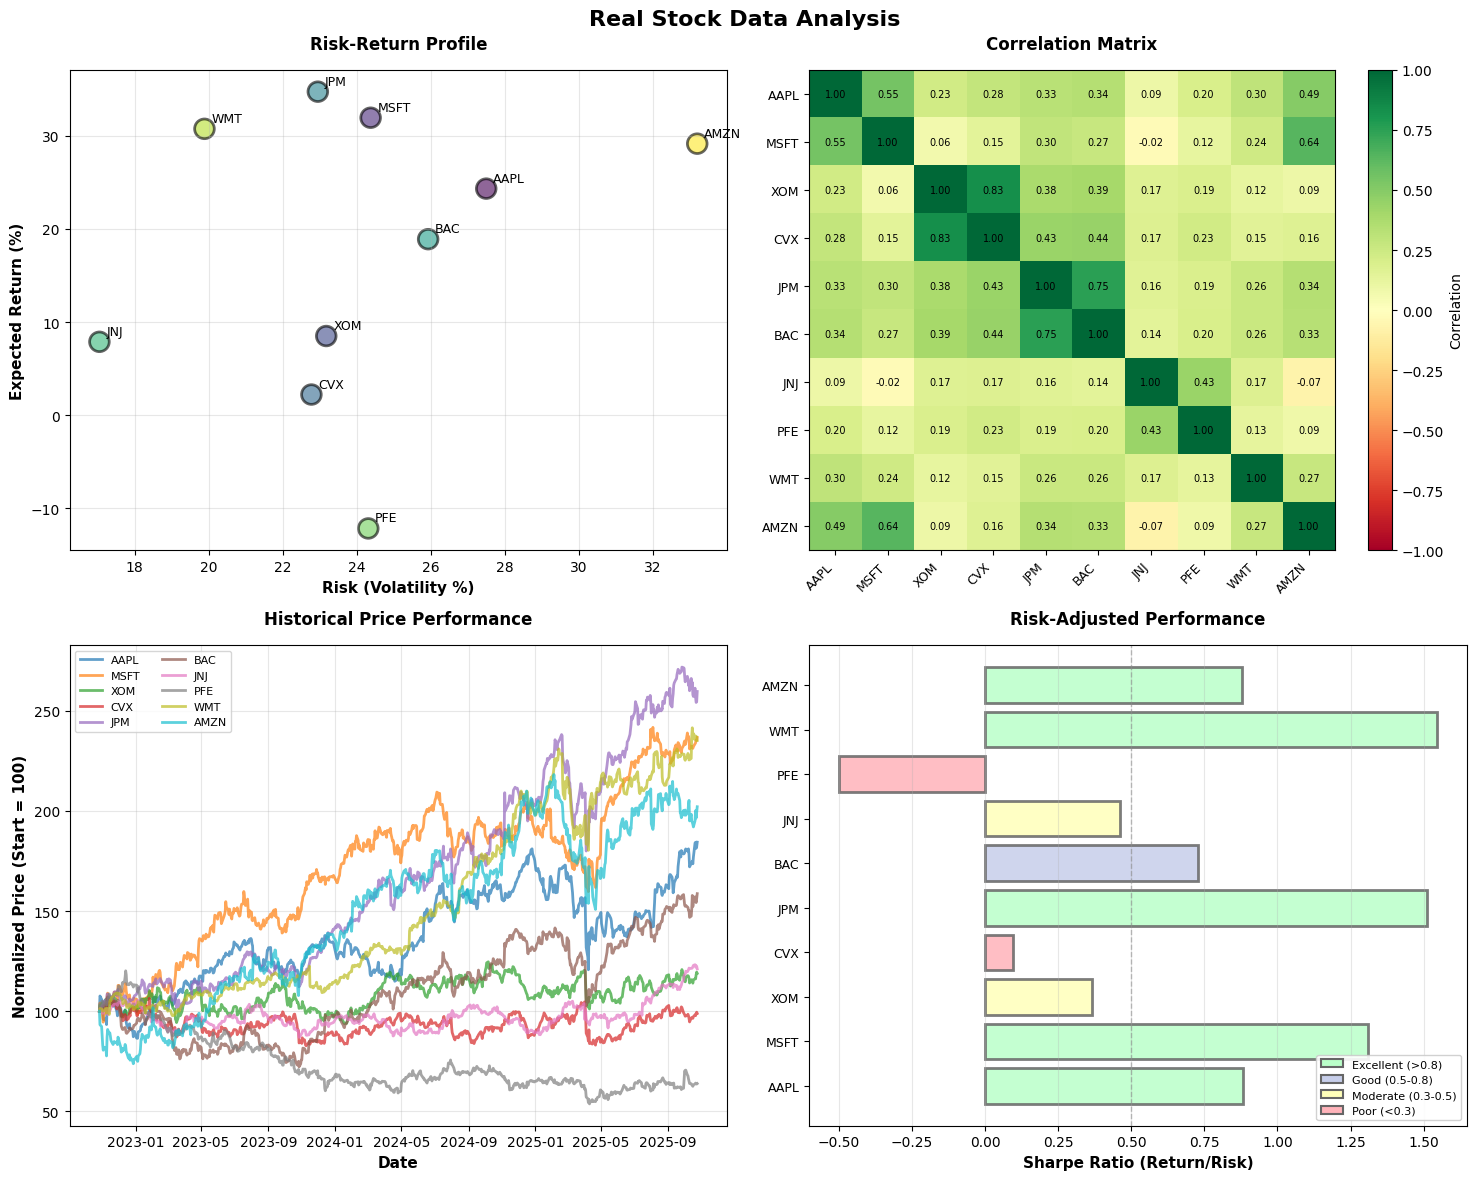

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Real Stock Data Analysis', fontsize=16, fontweight='bold')

# Plot 1: Return vs Risk - CLEAR COLORS (viridis)
ax1 = axes[0, 0]
colors = plt.cm.viridis(np.linspace(0, 1, n_assets))
scatter = ax1.scatter(volatility, expected_returns, s=200, c=colors, 
                     alpha=0.6, edgecolors='black', linewidth=2)

for i in range(n_assets):
    ax1.annotate(tickers[i], (volatility[i], expected_returns[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

ax1.set_xlabel('Risk (Volatility %)', fontweight='bold', fontsize=11)
ax1.set_ylabel('Expected Return (%)', fontweight='bold', fontsize=11)
ax1.set_title('Risk-Return Profile', fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3)

# Plot 2: Correlation Heatmap - CLEAR COLORS (RdYlGn)
ax2 = axes[0, 1]
im = ax2.imshow(correlation_matrix, cmap='RdYlGn', vmin=-1, vmax=1, aspect='auto')
ax2.set_xticks(range(n_assets))
ax2.set_yticks(range(n_assets))
ax2.set_xticklabels(tickers, rotation=45, ha='right', fontsize=9)
ax2.set_yticklabels(tickers, fontsize=9)
ax2.set_title('Correlation Matrix', fontweight='bold', pad=15)
plt.colorbar(im, ax=ax2, label='Correlation')

for i in range(n_assets):
    for j in range(n_assets):
        text = ax2.text(j, i, f'{correlation_matrix[i, j]:.2f}',
                       ha="center", va="center", color="black", fontsize=7)

# Plot 3: Historical prices - CLEAR COLORS (tab10)
ax3 = axes[1, 0]
normalized_prices = data / data.iloc[0] * 100
colors_tab10 = plt.cm.tab10(np.linspace(0, 1, n_assets))

for i, ticker in enumerate(tickers):
    ax3.plot(normalized_prices.index, normalized_prices[ticker], 
            label=ticker, alpha=0.7, linewidth=2, color=colors_tab10[i])

ax3.set_xlabel('Date', fontweight='bold', fontsize=11)
ax3.set_ylabel('Normalized Price (Start = 100)', fontweight='bold', fontsize=11)
ax3.set_title('Historical Price Performance', fontweight='bold', pad=15)
ax3.legend(loc='best', fontsize=8, ncol=2)
ax3.grid(True, alpha=0.3)

# Plot 4: Sharpe Ratio - PASTEL COLORS (only this one!)
ax4 = axes[1, 1]
sharpe_ratios = expected_returns / volatility

# PASTEL colors based on Sharpe ratio
bar_colors = []
for s in sharpe_ratios:
    if s > 0.8:
        bar_colors.append('#BAFFC9')  # Light green - excellent
    elif s > 0.5:
        bar_colors.append('#C7CEEA')  # Light lavender - good
    elif s > 0.3:
        bar_colors.append('#FFFFBA')  # Light yellow - moderate
    else:
        bar_colors.append('#FFB3BA')  # Light pink - poor

bars = ax4.barh(range(n_assets), sharpe_ratios, color=bar_colors, 
               alpha=0.85, edgecolor='#666666', linewidth=2)
ax4.set_yticks(range(n_assets))
ax4.set_yticklabels(tickers, fontsize=9)
ax4.set_xlabel('Sharpe Ratio (Return/Risk)', fontweight='bold', fontsize=11)
ax4.set_title('Risk-Adjusted Performance', fontweight='bold', pad=15)
ax4.grid(axis='x', alpha=0.3)
ax4.axvline(x=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Add PASTEL legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#BAFFC9', edgecolor='#666666', linewidth=1.5, label='Excellent (>0.8)'),
    Patch(facecolor='#C7CEEA', edgecolor='#666666', linewidth=1.5, label='Good (0.5-0.8)'),
    Patch(facecolor='#FFFFBA', edgecolor='#666666', linewidth=1.5, label='Moderate (0.3-0.5)'),
    Patch(facecolor='#FFB3BA', edgecolor='#666666', linewidth=1.5, label='Poor (<0.3)')
]
ax4.legend(handles=legend_elements, loc='lower right', fontsize=8, framealpha=0.9)

plt.tight_layout()
plt.savefig('stock_data_analysis.png', dpi=150, bbox_inches='tight')

plt.show()

In [5]:
output_file = 'real_stock_data.py'

with open(output_file, 'w', encoding='utf-8') as f:
    f.write('"""\n')
    f.write('STOCK DATA FOR QUBO PORTFOLIO OPTIMIZATION\n')
    f.write(f'Generated: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}\n')
    f.write(f'Period: {data.index[0].strftime("%Y-%m-%d")} to {data.index[-1].strftime("%Y-%m-%d")}\n')
    f.write(f'Trading days: {len(data)}\n')
    f.write('"""\n\n')
    f.write('import numpy as np\n\n')
    f.write(f'n_assets = {n_assets}\n\n')
    
    f.write('asset_names = [\n')
    for name in asset_names:
        f.write(f"    '{name}',\n")
    f.write(']\n\n')
    
    f.write('expected_returns = np.array([')
    f.write(', '.join([f'{val:.2f}' for val in expected_returns]))
    f.write('])\n\n')
    
    f.write('volatility = np.array([')
    f.write(', '.join([f'{val:.2f}' for val in volatility]))
    f.write('])\n\n')
    
    f.write('covariance_matrix = np.array([\n')
    for row in covariance_matrix:
        f.write('    [' + ', '.join([f'{val:8.2f}' for val in row]) + '],\n')
    f.write('])\n\n')
    
    f.write('# QUBO parameters\n')
    f.write('budget = 5\n')
    f.write('risk_factor = 0.003\n')
    f.write('return_factor = 3.0\n')
    f.write('penalty = 150.0\n')
    f.write('reps = 3\n')

print(f"\n Data exported to: {output_file}")




 Data exported to: real_stock_data.py
